[![Shorenstein Logo](https://shorensteincenter.org/wp-content/uploads/2014/08/cropped-cropped-HKSlogo_shorenstein.png)](https://shorensteincenter.org/)

# Table of Contents:
###  0 [import libraries](#0-bullet)
###  1 [Pull Data from the API](#1-bullet)
###  2 [Turn the Data into a pandas DataFrame](#2-bullet)
###  3 [Explore the Data](#3-bullet)
#####      - 3.1[Basic Engagement by Individual User](#3.1-bullet)
#####      - 3.2[ Last Active by Individual User](#3.2-bullet)
#####      - 3.3[Two-Dimensional Distributions ](#3.3-bullet)
#####      - 3.4[Time on List for Unsubscribed Users](#3.4-bullet)

# 0. Import libraries and set global variables <a class="anchor" id="0-bullet"></a>

In [1]:
# set colors 
c1='#18a45f' # subs 
c2='#ec3038' # unsubs
c3='#3286ec' # cleaned
c4='#fecf5f' # pending
c_ev= '#cccccc'
c_nev='#000000' 
c12m = '#016d2c'#'12 months' 
c9m ='#31a354' #'9 months '
c6m =  '#74c476' #'6 months'  
c3m= '#bae4b3' #'3 months' 
c1m = '#edf8e9'#'1 month' 

In [2]:
# import libraries
%matplotlib inline
import os
from mailchimp3 import MailChimp # import your wrapper of choice for your email service provider - in this case mailchimp3; learn more about mailchimp3:https://github.com/charlesthk/python-mailchimp/blob/master/README.md
import pandas as pd # standard code for importing the pandas library and aliasing it as pd - if you want to learn all about pandas read 'Python for Data Analysis' version 2nd Edition by Wes McKinney, the creator of pandas
import time # allows you to time things 
import matplotlib.pyplot as plt # allows you to plot data  
import seaborn as sns # makes the plots look nicer
import numpy as np
import os
import glob

# 1. Pull data from API

In [3]:
# run this cell to initialize variables to pull data from the API of your email service provider, in this case MailChimp
# replace the variable values in quotes in red caps with the unique values for your MailChimp account
# if this request times out, pull via batch request -- which is slower but the recommended method by MailChimp
LIST_NAME='ONA_Test'
# NAME='YOURUSERNAME'# your MailChimp user name (used at login)
# SECRET_KEY='YOURAPIKEY' # your MailChimp API Key
# LIST_ID='YOURLISTID' # the ID for the individual list you want to look at
# OUT_FILE='OUTFILENAME.csv'# if you want to export your data, you can speficy the outfile name and type, in this case CSV 

In [4]:
# make an output directory to explort the results and images from this notebook
oupt_dir='Shorenstein_Notebook_2_'+str(LIST_NAME)
try:
    os.mkdir(oupt_dir)
except:
    "marvelous!"

In [ ]:
# initalizes client - creates a connection with the API; calling that connection client 
# client=MailChimp(NAME,SECRET_KEY)

# lists_endpoint=client.lists.get(LIST_ID)

# read in data from Shorenstein Notebook 1, or pull it again 
# GET request pulling data from the MailChimp API - see documentation
# you can also read in a pkl or other file type if you already have this information from running Notebook 1
# member_data=client.lists.members.all(LIST_ID,get_all=True,
#                                   fields='members.status,members.email_address,members.timestamp_opt,members.timestamp_signup,members.member_rating,members.stats,members.id, members.last_changed, members.action, members.timestamp, members.unsubscribe_reason')

In [ ]:
# this is a function that gets the last 50 actions for each user on your list
# if it times out do a batch request
# def last_user_actions(userid):
#    """user id is a string that is the md5 hash of the lower case email.
#    this function gets the lasy 50 user actions and returns a dataframe of user actions"""
#    member_act_api=client.lists.members.activity.all(list_id=LIST_ID, subscriber_hash=userid)
#    member_act=pd.DataFrame(member_act_api['activity'])
#    member_act['id']=userid
#    return member_act

# create member list of unique member ids in your member data frame
# memb_list=list(pd.DataFrame(member_data['members'])['id'].unique())

# member_actions=pd.concat(map(last_user_actions,memb_list))
# parse the timestamp
# member_actions['timestamp']=member_actions.timestamp.apply(pd.to_datetime)

# 2. Turn the Data into a pandas Data Frame

In [5]:
member_data_frame=pd.read_pickle('nb1_anon.pkl')

In [6]:
member_actions=pd.read_pickle('nb2_anon.pkl')

In [7]:
# turns the member_data returned by the API into a pandas data frame 
# member_data_frame=pd.DataFrame(member_data['members'])

# unpack open rate and click rate from stats for each record, add the value to a new column named open and click respectively
# create a column for those who never opened or clicked
# false = number of subscribers who have ever opened
# true = number of subscribers who have never opened 
member_data_frame['open']=member_data_frame.stats.apply(lambda x: x['avg_open_rate'])
member_data_frame['click']=member_data_frame.stats.apply(lambda x: x['avg_click_rate'])
member_data_frame['never_opened']=member_data_frame.open.apply(lambda x:x==0)
member_data_frame['never_clicked']=member_data_frame.click.apply(lambda x:x==0)

# preparing the data by calculating the month joined, and for each of those months, what % of those people are subscribed, unsubscribed, cleaned or pending. 
# NOTE: There is no output from this cell but you need to run it to see the graphs below. 
member_data_frame['timestamp_opt']=member_data_frame.timestamp_opt.apply(pd.to_datetime)
member_data_frame['timestamp_signup']=member_data_frame.timestamp_signup.apply(pd.to_datetime)

# records missing signup_time
print sum(member_data_frame.timestamp_signup.isnull())

44879


In [8]:
# make sure index is unique because we are about to do some manipulations based on it
member_data_frame.reset_index(drop=True,inplace=True)

# index of members where we don't know when the signed up but we have opt in time
guess_time_ix=member_data_frame[(member_data_frame.timestamp_signup.isnull())&
                               (member_data_frame.timestamp_opt.isnull()!=True)].index

# when we don't have signup time use opt in time
member_data_frame.loc[guess_time_ix,'timestamp_signup']=member_data_frame.loc[guess_time_ix,'timestamp_opt']

# use integer division to break down people in to groups by the month they joined
member_data_frame['join_month']=member_data_frame.timestamp_signup.apply(lambda x:pd.to_datetime(2592000*int((x.value/1e9)/2592000),unit='s'))
 

# represent the joined month as an interger of ms since epoch time 0
# this format is not nice for people but very nice for computers
member_data_frame['jv']=member_data_frame.join_month.apply(lambda x: x.value)
member_data_frame['jv']=member_data_frame.join_month.apply(lambda x: x.value)

member_actions['timestamp']=member_actions.timestamp.apply(pd.to_datetime)


# slice to only look at opens
memb_open=member_actions[member_actions.action=='open']

# get last open
last_open=memb_open.groupby('id').timestamp.max().reset_index()
# get oldest open
old_open=memb_open.groupby('id').timestamp.min().reset_index()
# clean name
last_open.columns=['id','last']
old_open.columns=['id','old']
# merge
open_time=pd.merge(last_open,old_open, how='left',on='id')
# get ms time
open_time['lv']=open_time['last'].apply(lambda x: x.value)
open_time['ov']=open_time['old'].apply(lambda x: x.value)

# add member open times to member data frame
member_data_frame=pd.merge(member_data_frame,open_time, how='left',on='id')

member_data_frame['latestv']=member_data_frame['last'].apply(lambda x: x.value)

member_last_not_null=member_data_frame[member_data_frame['last'].isnull()!=True]

import time

# get todays date
a=pd.to_datetime(time.time(),unit='s')

# slices dataframe into 12 months, 9 months, 6 months, 3 months and 1 month active subscribers
member_data_frame['12m']=member_data_frame['last'].apply(lambda x: x>(a-pd.to_timedelta('365D')))
member_data_frame['9m']=member_data_frame['last'].apply(lambda x: x>(a-pd.to_timedelta('274D')))
member_data_frame['6m']=member_data_frame['last'].apply(lambda x: x>(a-pd.to_timedelta('183D')))
member_data_frame['3m']=member_data_frame['last'].apply(lambda x: x>(a-pd.to_timedelta('91D')))
member_data_frame['1m']=member_data_frame['last'].apply(lambda x: x>(a-pd.to_timedelta('30D')))

# get monthly activity as a fraction of all users who joined that month
monthly_act=member_data_frame.groupby('join_month').agg({'12m':sum,
                                            '9m':sum,
                                            '6m':sum,
                                            '3m':sum,
                                            '1m':sum,
                                            'id':lambda x: x.size}).reset_index()

monthly_act.rename(columns={'id':'tot'},inplace=True)
monthly_act['1m_per']=monthly_act.apply(lambda x: x['1m']/float(x['tot']),axis=1)
monthly_act['3m_per']=monthly_act.apply(lambda x: x['3m']/float(x['tot']),axis=1)
monthly_act['6m_per']=monthly_act.apply(lambda x: x['6m']/float(x['tot']),axis=1)
monthly_act['9m_per']=monthly_act.apply(lambda x: x['9m']/float(x['tot']),axis=1)
monthly_act['12m_per']=monthly_act.apply(lambda x: x['12m']/float(x['tot']),axis=1)
unsubscribe_times=member_actions[member_actions.action=='unsub'][['id','timestamp']].copy()
unsubscribe_times.rename(columns={'timestamp':'unsub_time'},inplace=True)
unsubscribe_times['unsubv']=unsubscribe_times.unsub_time.apply(lambda x: x.value/1e9)
member_data_frame=pd.merge(member_data_frame,unsubscribe_times, how='left',on='id')
member_data_frame['life']=member_data_frame.apply(lambda x:x['unsub_time']-x['timestamp_opt'],axis=1)

# 3. Explore the data

## 3.1  Basic Engagement by Individual User
### We go from asking, 'What is the (unique) open rate for your list?'

In [ ]:
# list_open_rate=lists_endpoint['stats']['open_rate']
# print list_open_rate

### To asking 'What is the distribution of user unique open rates for current subscribers vs. unsubscribes?' 

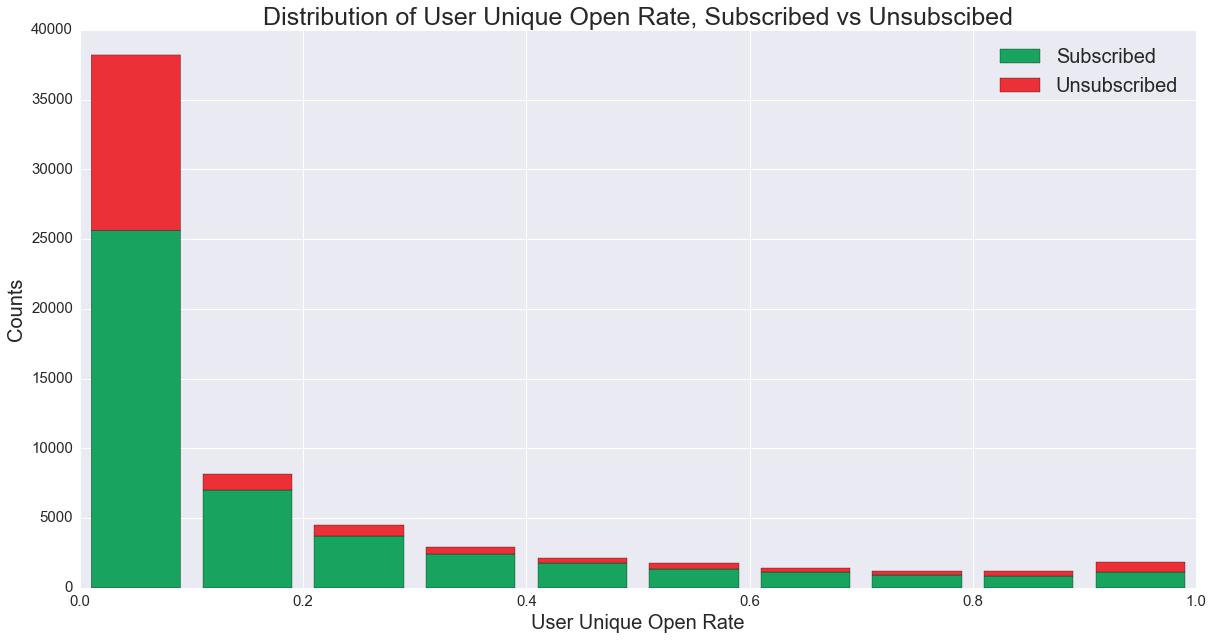

In [9]:
# user unique open rate = unique open rate for an individual on your list
# calculation: (number of unique opens by a user / number of campaigns received by that user) x 100  
plt.figure(figsize=(20,10))
plt.hist([member_data_frame[member_data_frame.status=='subscribed'].open,
          member_data_frame[member_data_frame.status=='unsubscribed'].open], stacked=True,
         normed=False,label=['Subscribed',
                             'Unsubscribed'],
        color=[c1,c2])


plt.title('Distribution of User Unique Open Rate, Subscribed vs Unsubscibed',fontdict={'fontsize':25})
plt.xlabel("User Unique Open Rate",fontdict={'fontsize':20})
plt.ylabel("Counts",fontdict={'fontsize':20})
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(loc='best', prop={'size': 20})
plt.savefig(oupt_dir+'/3.1_dist_open_sub_vs_unsub.png')
plt.show()

### What is the distribution of user unique click rates for current subscribers vs. unsubscribed users? 

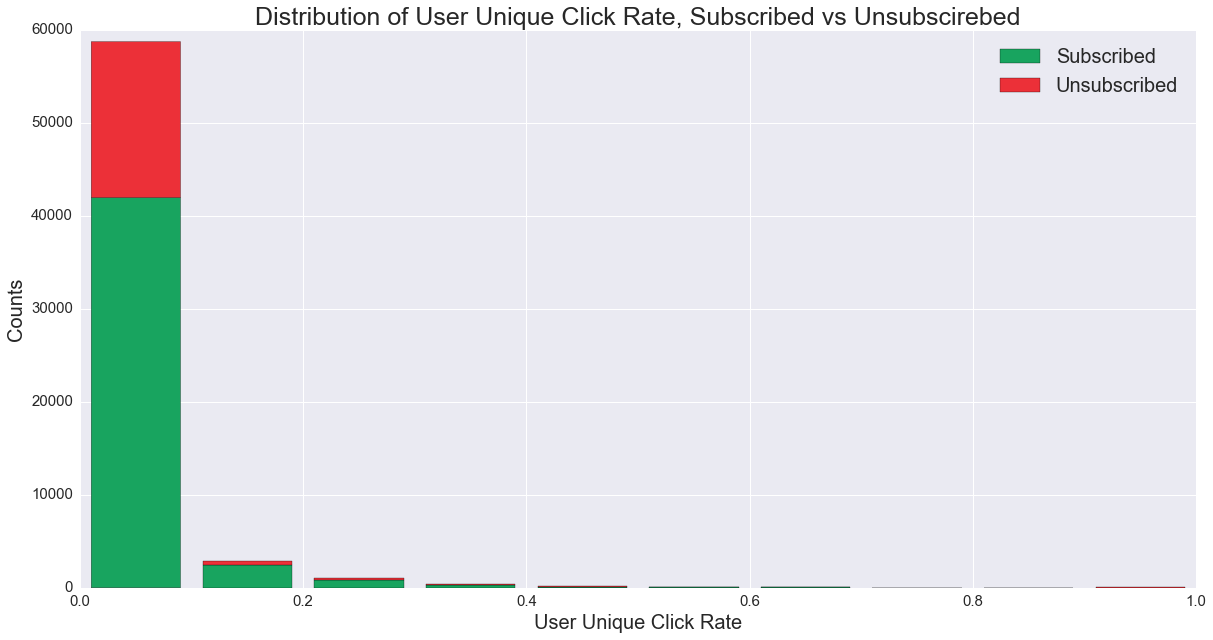

In [10]:
plt.figure(figsize=(20,10))
plt.hist([member_data_frame[member_data_frame.status=='subscribed'].click,
          member_data_frame[member_data_frame.status=='unsubscribed'].click], stacked=True,
         normed=False,label=['Subscribed',
                             'Unsubscribed'],
        color=[c1,c2])

plt.title('Distribution of User Unique Click Rate, Subscribed vs Unsubscirebed',fontdict={'fontsize':25})
plt.xlabel("User Unique Click Rate",fontdict={'fontsize':20})
plt.ylabel("Counts",fontdict={'fontsize':20})
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(loc='best', prop={'size': 20})
plt.savefig(oupt_dir+'/3.1_dist_click_sub_vs_unsub.png')
plt.show()

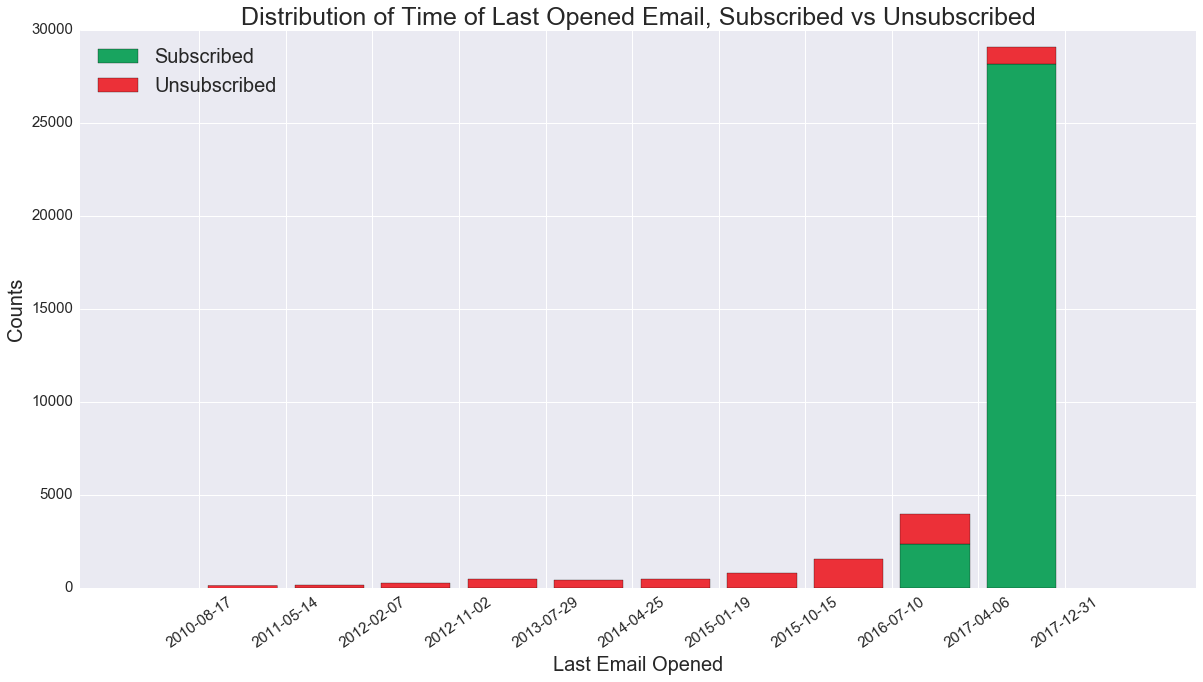

In [11]:
plt.figure(figsize=(20,10))

ax=plt.hist([member_last_not_null[member_last_not_null.status=='subscribed'].latestv,
          member_last_not_null[member_last_not_null.status=='unsubscribed'].latestv], stacked=True,
         normed=False,label=['Subscribed',
                             'Unsubscribed'],
        color=[c1,c2])

plt.xticks(ax[1],map(lambda x: pd.to_datetime(x).date(),ax[1]), rotation=35)

plt.title('Distribution of Time of Last Opened Email, Subscribed vs Unsubscribed',fontdict={'fontsize':25})

plt.ylabel("Counts",fontdict={'fontsize':20})
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Last Email Opened',fontdict={'fontsize':20})
plt.legend(loc='best', prop={'size': 20})
plt.savefig(oupt_dir+'/3.1_distlast_opened_sub_vs_unsub.png')
plt.show()

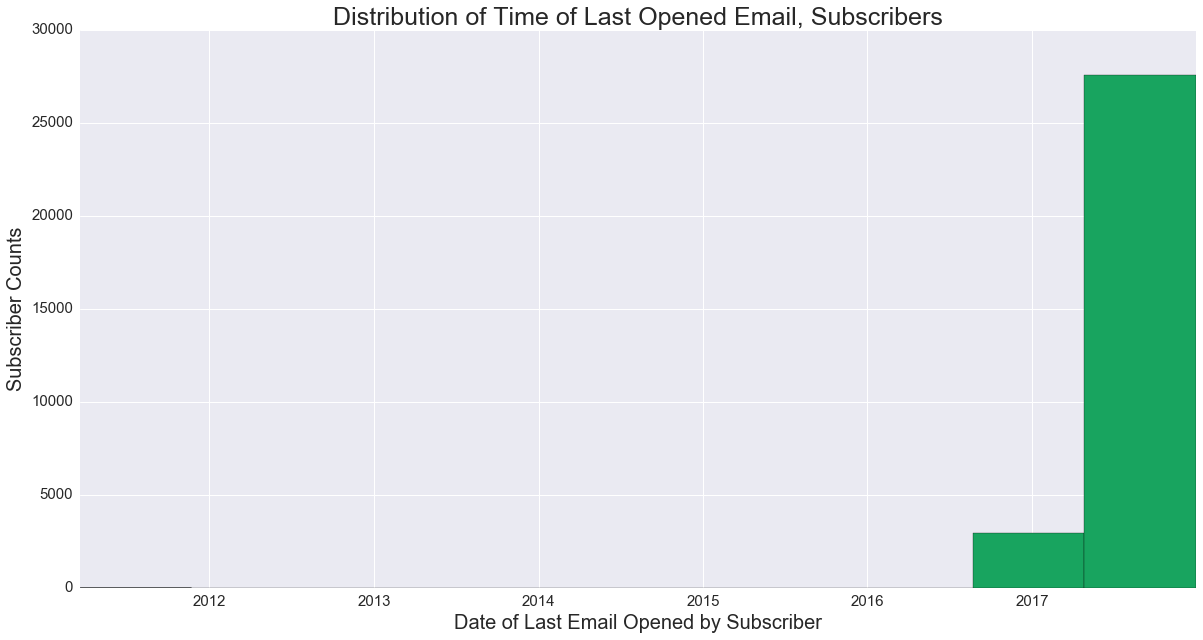

In [12]:
plt.figure(figsize=(20,10))
plt.title('Distribution of Time of Last Opened Email, Subscribers',fontdict={'fontsize':25})
member_data_frame[member_data_frame.status=='subscribed']['last'].hist(label='SUBSCRIBED',color=c1)
plt.xlabel('Date of Last Email Opened by Subscriber',fontdict={'fontsize':20})
plt.ylabel("Subscriber Counts",fontdict={'fontsize':20})
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig(oupt_dir+'/4_last_opens_sub.png')

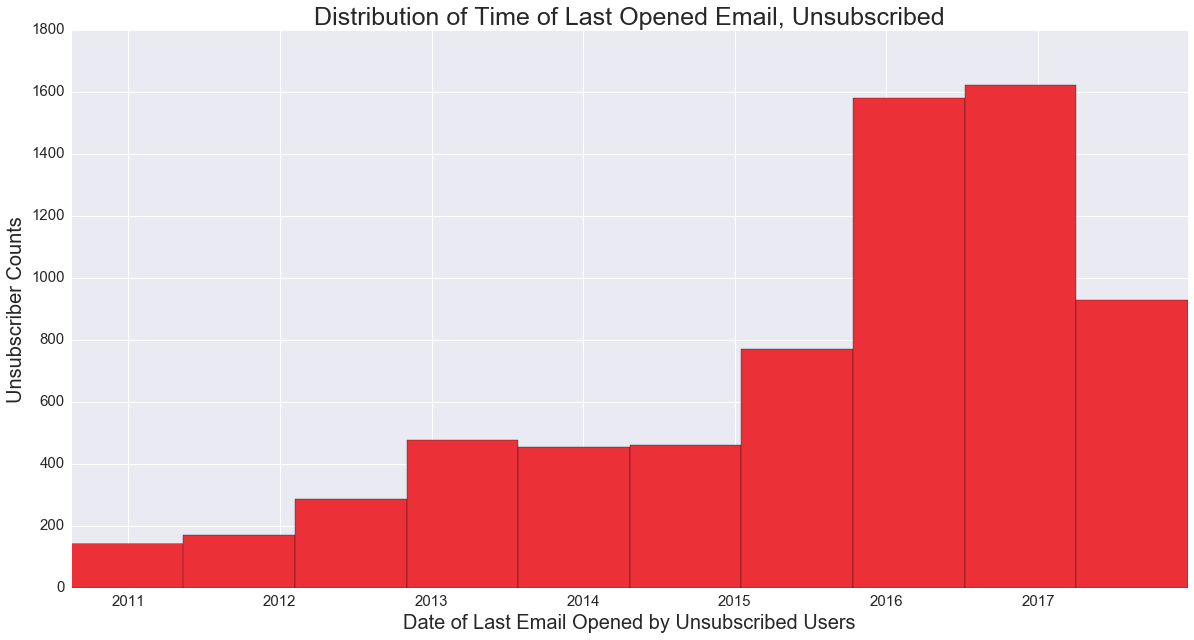

In [13]:
plt.figure(figsize=(20,10))
plt.title('Distribution of Time of Last Opened Email, Unsubscribed',fontdict={'fontsize':25})
member_data_frame[member_data_frame.status=='unsubscribed']['last'].hist(label='UNSUBSCRIBED',color=c2)
plt.xlabel('Date of Last Email Opened by Unsubscribed Users',fontdict={'fontsize':20})
plt.ylabel("Unsubscriber Counts",fontdict={'fontsize':20})
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig(oupt_dir+'/5_last_opens_unsub.png')

## 3.2  Last Active by Individual User
### Number of current subscribers who have opened an email in the last: 12 months, 9 months, 6 months, 3 months 

In [14]:
m12_act=member_data_frame['12m'].sum()
print m12_act

31195


In [15]:
m9_act=member_data_frame['9m'].sum()
print m9_act

28098


In [16]:
m6_act=member_data_frame['6m'].sum()
print m6_act

23915


In [17]:
m3_act=member_data_frame['3m'].sum()
print m3_act

13677


In [18]:
m1_act=member_data_frame['1m'].sum()
print m1_act

0


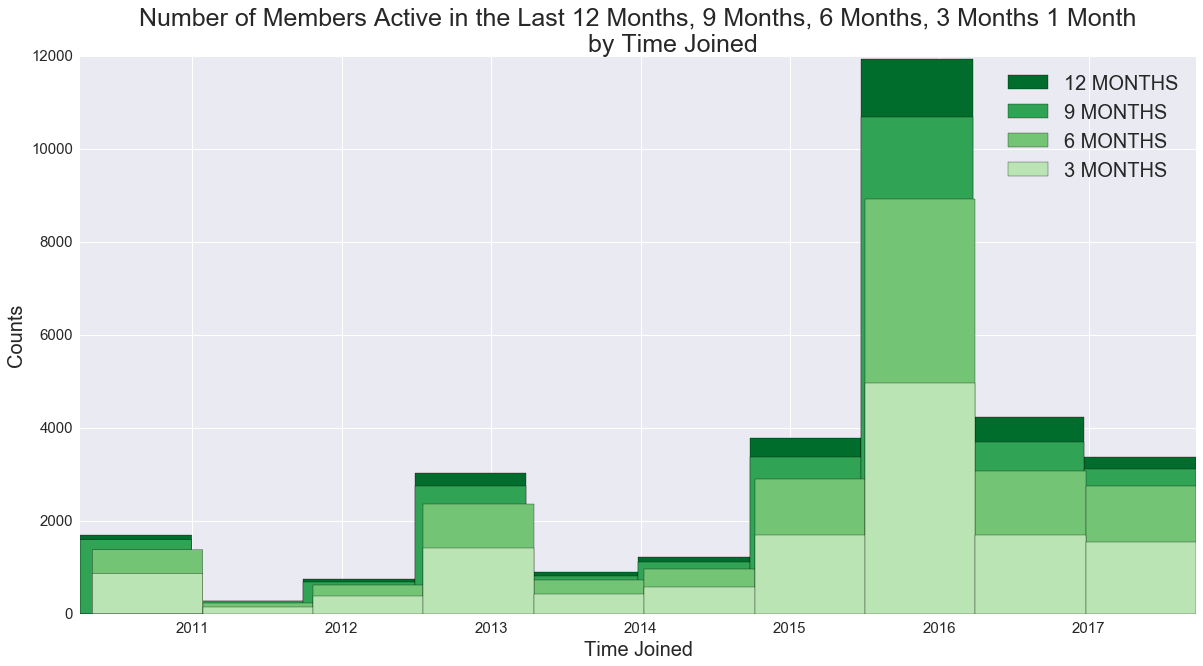

In [29]:
# stacked histogram showing number of members active in the last 12 months, 9 months, 6 months, 3 months, 1 month 
plt.figure(figsize=(20,10))
member_data_frame[member_data_frame['12m']==True].join_month.hist(label='12 MONTHS',color=c12m)
member_data_frame[member_data_frame['9m']==True].join_month.hist(label='9 MONTHS',color=c9m)
member_data_frame[member_data_frame['6m']==True].join_month.hist(label='6 MONTHS',color=c6m)
member_data_frame[member_data_frame['3m']==True].join_month.hist(label='3 MONTHS',color=c3m)
# member_data_frame[member_data_frame['1m']==True].join_month.hist(label='1 MONTH',color=c1m)
plt.legend(loc='best', prop={'size': 20})

plt.xlabel('Time Joined',fontsize=20)
plt.ylabel('Counts',fontdict={'fontsize':20})
plt.title('''Number of Members Active in the Last 12 Months, 9 Months, 6 Months, 3 Months 1 Month
          by Time Joined''',fontdict={'fontsize':25})
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig(oupt_dir+'/7_memb_active.png')

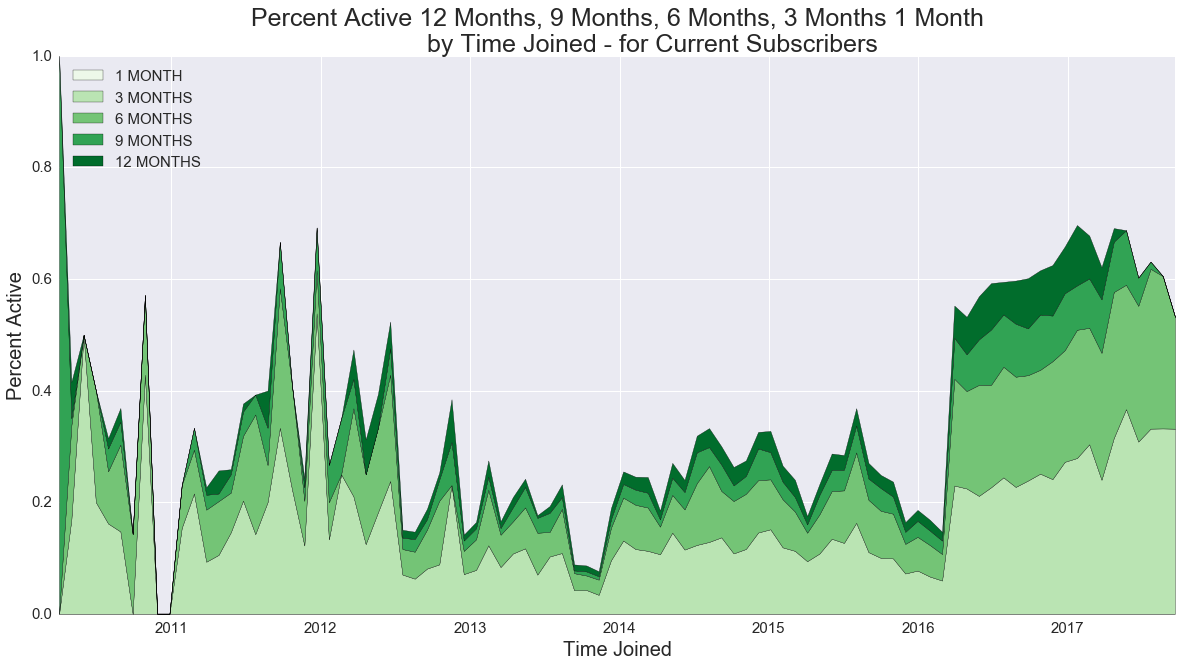

In [20]:
fig, ax = plt.subplots(figsize=(20,10))
ax.stackplot(list(monthly_act.join_month),monthly_act['1m_per'],
             monthly_act['3m_per']-monthly_act['1m_per'],
             monthly_act['6m_per']-monthly_act['3m_per'],
             monthly_act['9m_per']-monthly_act['6m_per'],
             monthly_act['12m_per']-monthly_act['9m_per'],labels=['1 MONTH','3 MONTHS','6 MONTHS',
                                                                 '9 MONTHS',
                                                                 '12 MONTHS'],
            colors=[c1m,c3m,c6m,c9m,c12m])
plt.legend(loc='upper left', prop={'size': 15})
plt.xlabel('Time Joined',fontdict={'fontsize':20})
plt.ylabel('Percent Active',fontdict={'fontsize':20})
plt.title('''Percent Active 12 Months, 9 Months, 6 Months, 3 Months 1 Month
          by Time Joined - for Current Subscribers''',fontdict={'fontsize':25})
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig(oupt_dir+'/6_percent_memb_active.png')
plt.show()


## 3.3 Two-Dimensional Distributions
### User unique open rate vs. when they joined, for subscribers

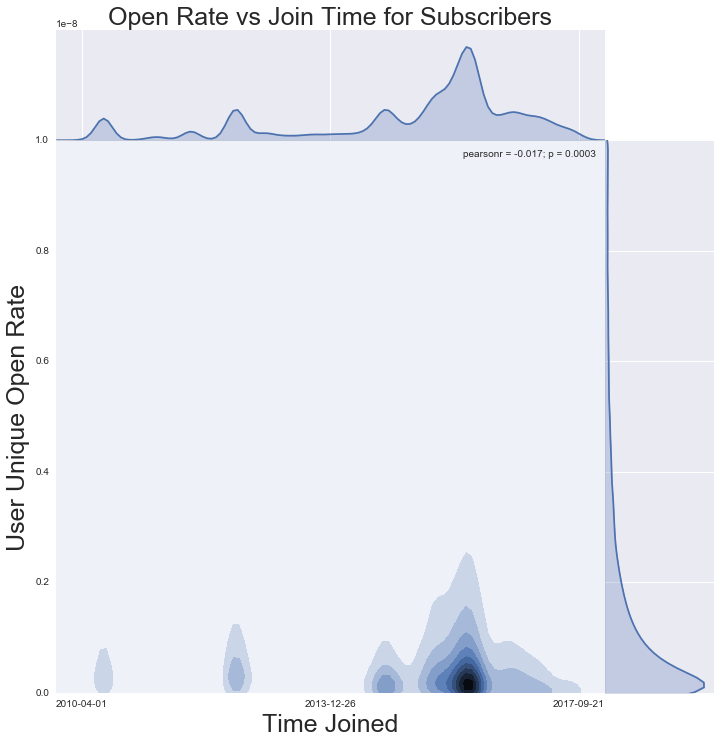

In [21]:
# open rate vs. when someone joined, for subscribers only 
# x axis = month they joined in miliseconds since 1970
# y axis is users unique open rate 

nxt=3 #number of x ticks
xrt=np.linspace(member_data_frame[member_data_frame.status=='subscribed'].jv.min(),
member_data_frame[member_data_frame.status=='subscribed'].jv.max(),num=nxt)
g=sns.jointplot(member_data_frame[member_data_frame.status=='subscribed'].jv/1e9,
                  member_data_frame[member_data_frame.status=='subscribed'].open,
                kind="kde",size=10, space=0,ylim=(0,1))
j=g.ax_joint
mx=g.ax_marg_x
my=g.ax_marg_y
mx.set_xticks(map(lambda x:x/1e9,xrt))
mx.set_xticklabels(map(lambda x: pd.to_datetime(x).date(),xrt))
mx.set_title("Open Rate vs Join Time for Subscribers",fontdict={'fontsize':25})
plt.rcParams["axes.labelsize"] = 25
g.set_axis_labels(xlabel='Time Joined',ylabel='User Unique Open Rate',fontdict={'fontsize':25})
g.savefig(oupt_dir+'/8_open_vs_join_sub.png')


### User unique open rate vs. time joined, for unsubscribers

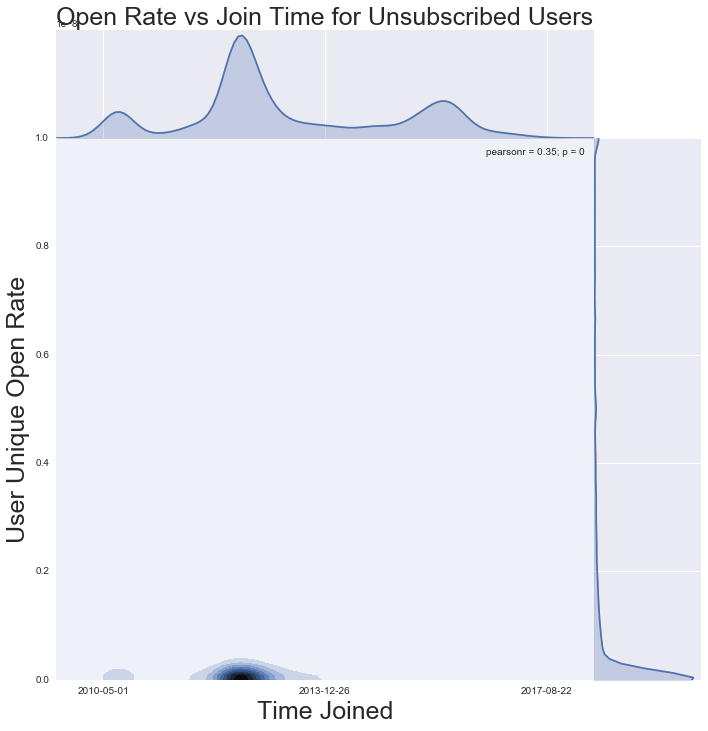

In [22]:
# x axis = month they joined in miliseconds since 1970
# y axis = user unique open rate

nxt=3 #number of x ticks
xrt=np.linspace(member_data_frame[member_data_frame.status=='unsubscribed'].jv.min(),
member_data_frame[member_data_frame.status=='unsubscribed'].jv.max(),num=nxt)

g = sns.jointplot(member_data_frame[member_data_frame.status=='unsubscribed'].jv/1e9,
                  member_data_frame[member_data_frame.status=='unsubscribed'].open,
                  ylim=(0,1),kind="kde", size=10, space=0)
j=g.ax_joint
mx=g.ax_marg_x
my=g.ax_marg_y
mx.set_xticks(map(lambda x:x/1e9,xrt))
mx.set_xticklabels(map(lambda x: pd.to_datetime(x).date(),xrt))
mx.set_title("Open Rate vs Join Time for Unsubscribed Users",fontdict={'fontsize':25})
g.set_axis_labels(xlabel='Time Joined',ylabel='User Unique Open Rate')

g.savefig(oupt_dir+'/9_open_vs_join_unsub.png')

### Time of the last email opened vs. time joined for subscribers 

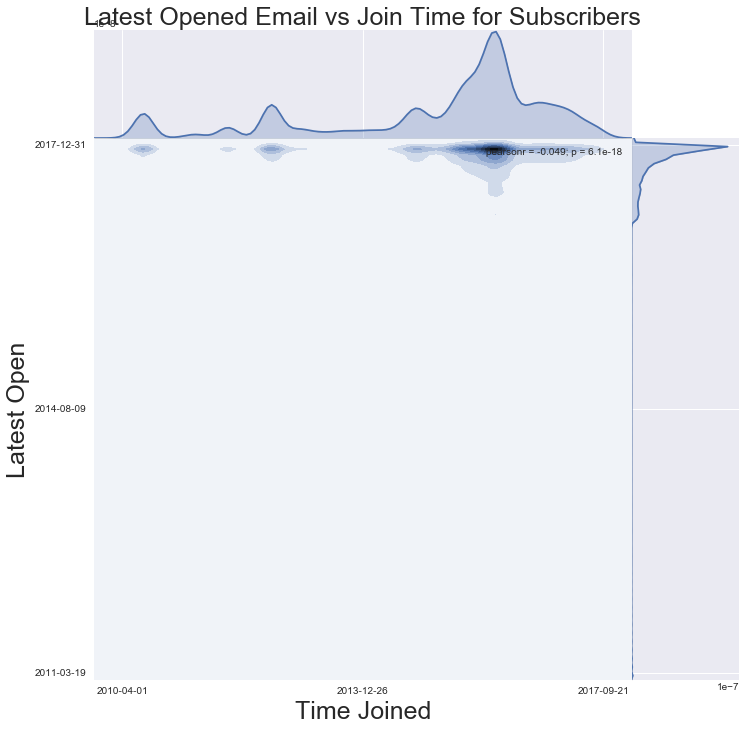

In [23]:
# x axis is distribution of when joined - farther to the right is joining more recently. 
# y axis is the oldest email record of opening in last 50 actions. 
# upper left is longtime engaged person, person who joined awhile ago who is still active 

nxt=3 #number of x ticks
nyt=3 #number of x ticks
xrt=np.linspace(member_data_frame[member_data_frame.status=='subscribed'].jv.min(),
member_data_frame[member_data_frame.status=='subscribed'].jv.max(),num=nxt)
yrt=np.linspace(member_data_frame[member_data_frame.status=='subscribed'].lv.min(),
member_data_frame[member_data_frame.status=='subscribed'].lv.max(),num=nxt)

g = sns.jointplot(member_data_frame[member_data_frame.status=='subscribed'].jv/1e9,
                  member_data_frame[member_data_frame.status=='subscribed'].lv/1e9, kind="kde", size=10, space=0)

j=g.ax_joint
mx=g.ax_marg_x
my=g.ax_marg_y
mx.set_xticks(map(lambda x:x/1e9,xrt))
mx.set_xticklabels(map(lambda x: pd.to_datetime(x).date(),xrt))
my.set_yticks(map(lambda x:x/1e9,yrt))
my.set_yticklabels(map(lambda x: pd.to_datetime(x).date(),yrt))
mx.set_title("Latest Opened Email vs Join Time for Subscribers",fontdict={'fontsize':25})
g.set_axis_labels(xlabel='Time Joined',ylabel='Latest Open')
g.savefig(oupt_dir+'/9_last_open_vs_join_sub.png')


### Joined Date vs Unsubscribed Date

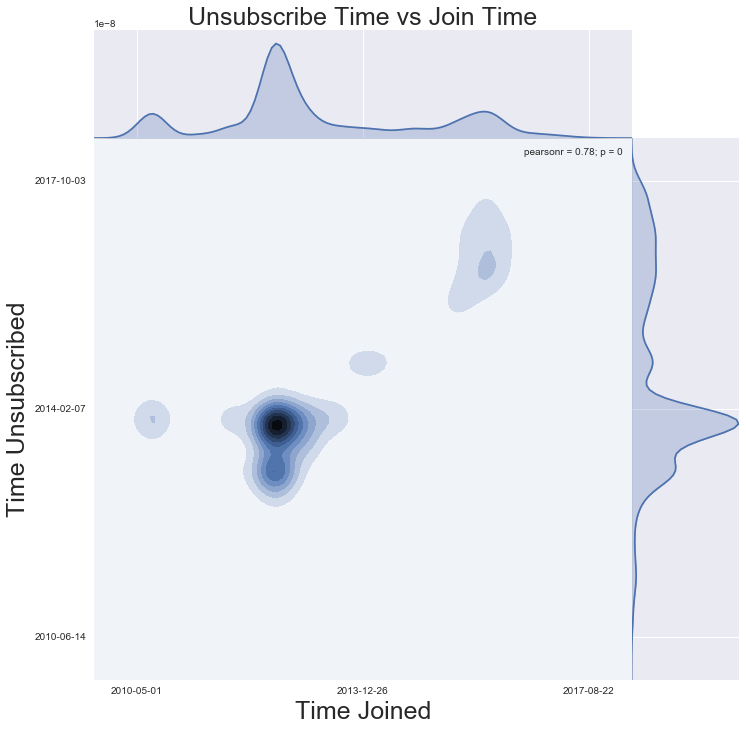

In [24]:
# x axis is distribution of when joined - farther to the right is joining more recently. 
# y axis is the oldest email record of opening in last 50 actions. 
# upper left is longtime engaged person, person who joined awhile ago who is still active 

nxt=3 # number of x ticks
nyt=3 # number of y ticks
xrt=np.linspace(member_data_frame[member_data_frame.status=='unsubscribed'].jv.min(),
member_data_frame[member_data_frame.status=='unsubscribed'].jv.max(),num=nxt)
yrt=np.linspace(member_data_frame[member_data_frame.status=='unsubscribed'].unsubv.min(),
member_data_frame[member_data_frame.status=='unsubscribed'].unsubv.max(),num=nyt)

g = sns.jointplot(member_data_frame[member_data_frame.status=='unsubscribed'].jv/1e9,
                  member_data_frame[member_data_frame.status=='unsubscribed'].unsubv/1e9, kind="kde", size=10, space=0)

j=g.ax_joint
mx=g.ax_marg_x
my=g.ax_marg_y
mx.set_xticks(map(lambda x:x/1e9,xrt))
mx.set_xticklabels(map(lambda x: pd.to_datetime(x).date(),xrt))
my.set_yticks(map(lambda x:x/1e9,yrt))
my.set_yticklabels(map(lambda x: pd.to_datetime(x,unit='s').date(),yrt))
mx.set_title("Unsubscribe Time vs Join Time",fontdict={'fontsize':25})
g.set_axis_labels(xlabel='Time Joined',ylabel='Time Unsubscribed')
g.savefig(oupt_dir+'/10_unusub_vs_join_unsub.png')

### Time of the last email opened vs. time joined for unsubscribers 

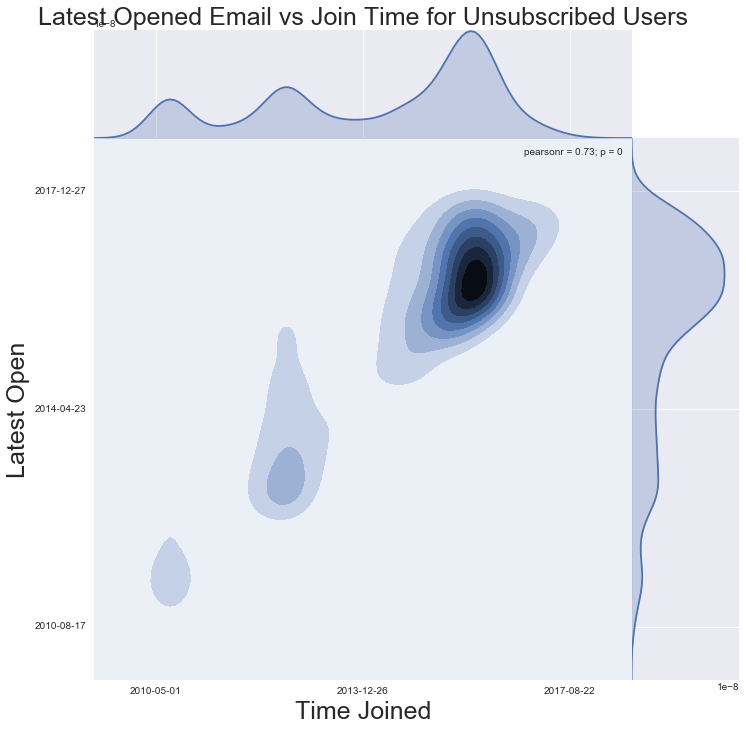

In [25]:
# x axis is distribution of when joined - farther to the right is joining more recently
# y axis is the oldest email record of opening in last 50 actions 
# upper left is longtime engaged user 
# upper right newer user recently opened

nxt=3 #number of x ticks
nyt=3 #number of x ticks
xrt=np.linspace(member_data_frame[member_data_frame.status=='unsubscribed'].jv.min(),
member_data_frame[member_data_frame.status=='unsubscribed'].jv.max(),num=nxt)
yrt=np.linspace(member_data_frame[member_data_frame.status=='unsubscribed'].lv.min(),
member_data_frame[member_data_frame.status=='unsubscribed'].lv.max(),num=nxt)

g = sns.jointplot(member_data_frame[member_data_frame.status=='unsubscribed'].jv/1e9,
                  member_data_frame[member_data_frame.status=='unsubscribed'].lv/1e9, kind="kde", size=10, space=0)

j=g.ax_joint
mx=g.ax_marg_x
my=g.ax_marg_y
mx.set_xticks(map(lambda x:x/1e9,xrt))
mx.set_xticklabels(map(lambda x: pd.to_datetime(x).date(),xrt))
my.set_yticks(map(lambda x:x/1e9,yrt))
my.set_yticklabels(map(lambda x: pd.to_datetime(x).date(),yrt))
mx.set_title("Latest Opened Email vs Join Time for Unsubscribed Users",fontdict={'fontsize':25})
g.set_axis_labels(xlabel='Time Joined',ylabel='Latest Open')
g.savefig(oupt_dir+'/12_last_open_vs_join_unsub.png')

## 3.4 Time on List for Unsubscribers 

In [26]:
# shortest time on the list before unsubscribing
# from the individual who unsubscribed the fastest
member_data_frame[member_data_frame.life.isnull()!=True].life.min()

Timedelta('-1713 days +16:53:41')

In [27]:
# longest time on the list before unsubscribing 
# from the individual who stayed on the longest before unsubscribing 
member_data_frame[member_data_frame.life.isnull()!=True].life.max()

Timedelta('2788 days 05:32:06')

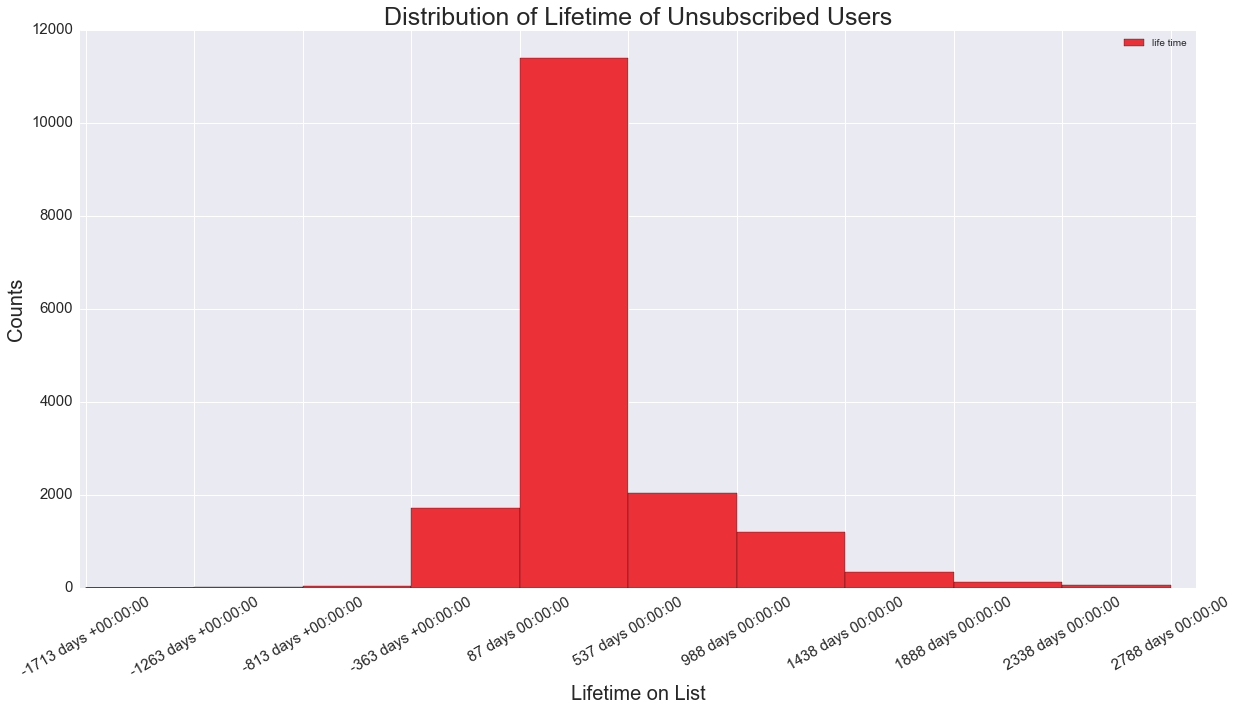

In [28]:
# histogram of time range each unsubscriber was on the list before they unsubscribed 
# depending on how granular you want to go and the lifetime of your list you may want to update bin size

plt.figure(figsize=(20,10))
ax=plt.hist([member_data_frame.dropna(subset=['life']).life.apply(lambda x:x.value)],label=['life time'],color=c2)
plt.xticks(ax[1],map(lambda x: pd.to_timedelta(x).floor('D'),ax[1]), rotation=30)
plt.title('Distribution of Lifetime of Unsubscribed Users',fontdict={'fontsize':25})
plt.xlabel('Lifetime on List',fontdict={'fontsize':20})
plt.ylabel('Counts',fontdict={'fontsize':20})
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(loc='best')
plt.savefig(oupt_dir+'/11_life_unsub.png')
plt.show()